# Parameteric prior approach

Short intro about conceptual idea of this method

Introduce prior distribution families for model parameters for toy example

In [ ]:
# import necessary libraries
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tfd = tfp.distributions 

from functions.loss_functions import MMD_energy
from setup.input_functions import param, model, target, loss, expert, optimization, prior_elicitation

### The model
The statistical model for our toy example can be written as follows:
$$
\begin{align*}
    \mu &\sim \text{Normal}(\mu_\mu, \sigma_\mu)\quad \quad &\text{Priors}\\
    \sigma &\sim \text{Normal}(0, \sigma_\sigma)\quad \quad &\\
    height_i &\sim \text{Normal}(\mu, \sigma) \quad \quad &\text{Likelihood}
\end{align*}
$$
Our goal is to find values for $\lambda = (\mu_\mu, \sigma_\mu, \sigma_\sigma)$.

For the implementation of the generative model we use the `model()` function which has the following arguments:
+ `model`: a class object which implements the generative model; its helpful for better organization to implement the class in a different file `generative_models` and then to import the class
+ `discrete_liklihood`: True or False; whether the likelihood function is discrete or not (if discrete an approximation method is used to compute the gradients)
+ `additional_model_args`: specification of optional arguments for the model class

In [2]:
# data-generating model
from user_input.generative_models import Model
def generative_model():
    return model(
        Model,
        discrete_likelihood=False,
        additional_model_args=None
        )

In [3]:
# user_input.generative_models > Model:
# implementation of the generative model 
# all input and output arguments are necessary arguments
class Model:
    def __call__(self, ground_truth, prior_samples):         

        # data-generating model
        likelihood = tfd.Normal(loc=prior_samples[:,:,0],
                                scale=prior_samples[:,:,1])
        
        # prior predictive distribution
        ypred = likelihood.sample()
        
        return dict(likelihood = likelihood,             
                    ypred = ypred,                 
                    epred = None,
                    prior_samples = prior_samples                 
                    )

Besides the implementation of the generative model, we need also to inform the elicitation method about the model parameters.
We define each model parameter within a tuple using the `param()` function:
+ `name`: string; name of the model parameter
+ `family`: tensorflow-probability distribution; parametric prior distribution family
+ `hyperparams_dict`: dict; keys represent the name of each hyperparameter and values represent initial value or distribution to sample initial value from (for starting generative approach)

In [4]:
# model parameters
def model_params():  
        return (
            param(
                name="mu",
                family=tfd.Normal,
                hyperparams_dict={
                    "mu_mu": tfd.Uniform(100.,200.),
                    "sigma_mu": tfd.Uniform(1., 30)
                    }
            ),
            param(
                name="sigma",
                family=tfd.HalfNormal,
                hyperparams_dict={
                    "mu_sigma": tfd.Uniform(1.,50.)
                    }
            )
        )

## Expert information (prior knowledge)
In general the expert will 


There are different techniques to elicit information from an expert. In the following we assume that we query an expert using a *quantile-based* technique.

**Example elicitation approach:**

The expert is asked w.r.t.
+ their *median* ($Q_{50}$; value for which there is a 50/50 chance of being more or less)
+ the lower and upper quartiles ($Q_{25}$ and $Q_{75}$ respectively; the expert should judge it to be equally likely for $y$ to be below $Q_{25}$ or between $Q_{25}$ and $Q_{50}$, and they should also judge it equally likely that $y$ would be between $Q_{50}$ and $Q_{75}$ or above $Q_{75}$.)
+ the lower and upper boundary ($Q_{5}$ and $Q_{95}$ respectively; equivalent to min and max but more stable)
+ a coherence check: $Q_{5} < Q_{25} < Q_{50} < Q_{75} < Q_{95}$ (ranking should not be violated)

A possible list of expert information could then look as follows:

+ $\hat t_1 = Q_{5\%}(height_i) = 153 cm$ 
+ $\hat t_2 = Q_{25\%}(height_i) = 166 cm$
+ $\hat t_3 = Q_{50\%}(height_i) = 170 cm$ (median)
+ $\hat t_4 = Q_{75\%}(height_i) = 174 cm$
+ $\hat t_5 = Q_{95\%}(height_i) = 186 cm$

To specify the elicitation technique we use the `target()` function:
+ `name`: str; name of the target quantity; here we use the prior predictive distribution
+ `elicitation_method`: str; specifies the elicitation technique used (currently supported: quantiles, histogram and moments)
+ `quantiles_specs`: tuple; only required if elicitation_method is quantiles; specifies the quantiles that should be computed from the target quantity
+ `loss_components`: str; specifies whether the quantiles should be trained as one loss component or in several loss components (currently supported: by-group, all)

Note: The function target_quantities() expects a tuple.

In [5]:
# elicited information
def target_quantities():
    return (
        target(
            name="ypred",
            elicitation_method="quantiles",
            quantiles_specs=(5, 25, 50, 75, 95),
            loss_components = "by-group"
            ),
        )   

Finally, we need to input the expert information to our method, which we can do via the `expert()` function. 

This function provides the possibility to 
+ provide a list with expert information for the `data` argument (e.g., a list with the five quantiles)
+ simulate a pre-specified ground truth by setting `simulate_data=True` (this will simulate from the generative model and compute all necessary elicited statistics as detailed below) 

We will simulate expert information by assuming the following *true* hyperparameter: $\mu_\mu=170$, $\sigma_\mu=2$, and $\sigma_\sigma=10$.
+ `simulator_specs`: dict; with this argument, we can specify the ground truth with keys being equal to model parameter names (must match with names specified in param functions) and
values representing the corresponding distribution functions with the true hyperparameter values. 
+ `rep`: int, specifies the number of samples drawn from the prior distributions

In [6]:
def expert_input():
    return expert(
        data=None,
        simulate_data=True,
        simulator_specs={
            "mu": tfd.Normal(170., 2.),
            "sigma": tfd.HalfNormal(10.),
            },
        rep=10_000
        ) 

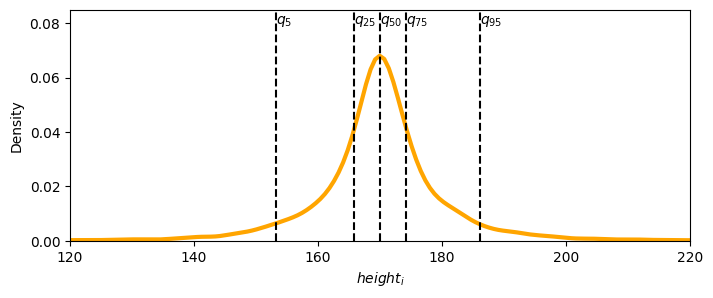

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[153.15569, 165.8458 , 169.97394, 174.12561, 186.1812 ]],
      dtype=float32)>

In [39]:
path = "elicit/simulations/results/data/parametric_prior/"
file = "toy_0"

ypred = pd.read_pickle(path+file+"/expert/model_simulations.pkl")["ypred"][0,:]
quantiles = pd.read_pickle(path+file+"/expert/elicited_statistics.pkl")["quantiles_ypred"]

_, axs = plt.subplots(1,1, figsize=(8,3))
sns.kdeplot(ypred, ax=axs, zorder=1, lw = 3, color="orange")
[axs.axvline(quantiles[0,i], zorder=2, linestyle="dashed", color="black") for i in range(quantiles.shape[-1])]
axs.set_xlim(120, 220)
axs.set_ylim(0, 0.085)
[axs.text(quantiles[0,i], 0.08, fr"$q_{{{p}}}$") for i,p in enumerate(["5","25","50","75","95"])] 
axs.set_xlabel(r"$height_i$ (in cm)")
plt.show()
quantiles

## Setting up the training

In [7]:
#%% Loss function
def loss_function():
    return loss(
        loss_function=MMD_energy,
        loss_weighting=None
        )
    
#%% Training settings
def optimization_settings():
    return optimization(
        optimizer=tf.keras.optimizers.Adam,
        optimizer_specs={
            "learning_rate": 0.05,  
            "clipnorm": 1.0
            }
        )

## Putting it all together

In [8]:
# run the training 
prior_elicitation(
    method = "parametric_prior",
    sim_id = "toy",
    B = 128,
    rep = 400,
    seed = 0,
    burnin = 100,
    epochs = 300,
    output_path = "results",
    param_independence = {
        "independent": True,
        "loss-scaling": 0.1
        },
    model_params = model_params,
    expert_input = expert_input,
    generative_model = generative_model,
    target_quantities = target_quantities,
    loss_function = loss_function,
    optimization_settings = optimization_settings,
    view_ep = 30,
    print_info = True
    )

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
epoch_time: 0.379 sec
Epoch: 0, loss: 11.07394, lr: 0.050000
epoch_time: 0.208 sec
Epoch: 30, loss: 6.49424, lr: 0.050000
Estimated time until completion: 00:00:57
epoch_time: 0.152 sec
Epoch: 60, loss: 5.21699, lr: 0.050000
Estimated time until completion: 00:00:50
epoch_time: 0.237 sec
Epoch: 90, loss: 4.96855, lr: 0.050000
Estimated time until completion: 00:00:43
epoch_time: 0.166 sec
Epoch: 120, loss: 4.62890, lr: 0.050000
Estimated time until completion: 00:00:37
epoch_time: 0.206 sec
Epoch: 150, loss: 4.16795, lr: 0.050000
Estimated time until completion: 00:00:31
epoch_time: 0.258 sec
Epoch: 180, loss: 3.45565, lr: 0.050000
Estimated time until completion: 00:00:25
epoch_time: 0.210 sec
Epoch: 210, loss: 3.16725, lr: 0.050000
Estimated time until completion: 00:00:19
epoch_time: 0.192 sec
Epoch: 240, loss: 3.06906, lr: 0.050000
Estimated time until completion: 00:00:12
epoch_ti

### Results

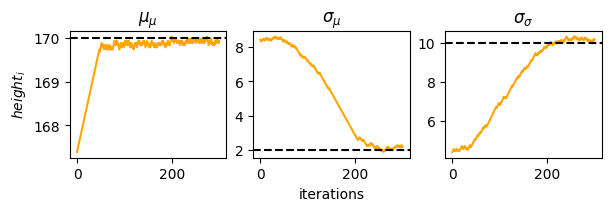

In [10]:
path = "elicit/simulations/results/data/parametric_prior/"
file = "toy_0"

hyperparam = pd.read_pickle(path+file+"/final_results.pkl")["hyperparameter"]

_, axs = plt.subplots(1,3, constrained_layout=True, figsize=(6,2))
[axs[i].plot(hyperparam[p], color="orange") for i,p in enumerate(["mu_mu", "sigma_mu", "mu_sigma"])]
[axs[i].set_title(t) for i,t in enumerate([r"$\mu_\mu$", r"$\sigma_\mu$", r"$\sigma_\sigma$"])] 
[axs[i].axhline(l, linestyle="dashed", color="black") for i,l in enumerate([170, 2, 10])] 
axs[1].set_xlabel("iterations")
axs[0].set_ylabel(r"$height_i$")
plt.show()

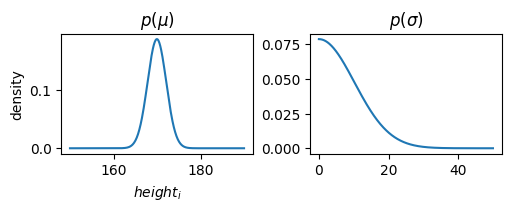

In [11]:
def compute_final_hyp(name, last_val=30):
    return tf.reduce_mean(pd.read_pickle(path+file+"/final_results.pkl")["hyperparameter"][name][-last_val:])

xrge_mu = tf.range(150., 190., 0.1)
xrge_sigma = tf.range(0., 50., 0.1)

prior_mu = tfd.Normal(
    loc=compute_final_hyp("mu_mu"),
    scale=compute_final_hyp("sigma_mu")
).prob(xrge_mu)

prior_sigma = tfd.HalfNormal(
    scale=compute_final_hyp("mu_sigma")
).prob(xrge_sigma)

_, axs = plt.subplots(1,2, constrained_layout=True, figsize=(5,2))
[axs[i].plot(xrge, par) for i, (xrge,par) in enumerate(zip([xrge_mu, xrge_sigma],[prior_mu, prior_sigma]))]
axs[0].set_xlabel(r"$height_i$")
axs[0].set_ylabel("density")
[axs[i].set_title(t) for i,t in enumerate([r"$p(\mu)$", r"$p(\sigma)$"])]
plt.show()

In [25]:
import numpy as np
quantiles = tf.round(tf.reduce_mean(pd.read_pickle(path+file+"/elicited_statistics.pkl")["quantiles_ypred"], axis=0))
pd.DataFrame(
    quantiles,
    columns=["quantiles"], 
    index = ["5%", "25%", "50%", "75%","95%"]
)

,quantiles
5%,154.0
25%,166.0
50%,170.0
75%,174.0
95%,186.0
